In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/diamonds.csv')
data = data.drop('Unnamed: 0', axis = 1)
data

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [3]:
#Проверка на пропуски
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [4]:
#Необходимо закодировать категориальные признаки - делаем через OHE

data_prep = pd.get_dummies(data, drop_first=True, dtype=int)
data_prep

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,1,0,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,1,...,1,0,0,0,0,1,0,0,0,0


In [5]:
#Делаем таргет и признаки
X = data_prep.drop('price', axis=1)
y = data['price']

In [6]:
X.shape

(53940, 23)

In [6]:
#Делим на трейн и тест
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
ytrain.shape

(37758,)

In [7]:
#Нормализация данных

sc = StandardScaler()
Xtrain = sc.fit_transform(Xtrain)
Xtest = sc.transform(Xtest)

In [8]:
ytrain_array = np.array(ytrain)
ytest_array = np.array(ytest)

In [9]:
#Теперь нам надо перевести данные в тензор

Xtrain_tensor = torch.tensor(Xtrain, dtype=torch.float32)
ytrain_tensor = torch.tensor(ytrain_array, dtype=torch.float32)

Xtest_tensor = torch.tensor(Xtest, dtype=torch.float32)
ytest_tensor = torch.tensor(ytest_array, dtype=torch.float32)

In [10]:
#Пишем Dataloader (но перед этим соединяем x и y)

data_train = TensorDataset(Xtrain_tensor, ytrain_tensor)
data_test = TensorDataset(Xtest_tensor, ytest_tensor)

In [ ]:
print(data_train)

In [11]:
batch = 16

train_loader = DataLoader(data_train, batch_size=batch, shuffle=True)
test_loader = DataLoader(data_test, batch_size= batch, shuffle=False)

In [12]:
#Теперь будем писать архитектуру нейронной сети (попробуем только один скрытый слой (с одним слоем совсем не считал, пришлось сделать два слоя))

class NeuralNet(nn.Module):
  def __init__(self, input_size = 23, hidden_size = 64, hidden_size_2 = 32):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size_2)
    self.fc3 = nn.Linear(hidden_size_2, 1)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

model = NeuralNet()

In [13]:
#Добавим вместо dropout batchnorm, чтобы улучшить ситуацию и теперь добавим еще слой
class NeuralNet_2(nn.Module):
    def __init__(self, input_size=23, hidden_size=64, hidden_size_2=23):
        super(NeuralNet_2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # BatchNorm1d после первого Linear
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, input_size)
        self.bn3 = nn.BatchNorm1d(input_size)
        self.fc4 = nn.Linear(input_size, 1)


    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

model_2 = NeuralNet_2()

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)

In [15]:
def train_model(train_loader, model, criterion, optimizer):
    model_2.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        targets = targets.view(-1, 1)
        optimizer.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [16]:

def evaluate_model(test_loader, model, criterion):
    model_2.eval()
    actuals = []
    predictions = []
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model_2(inputs)
            loss = criterion(outputs, targets.view(-1, 1))  # Вычисляем лосс для текущего батча
            running_loss += loss.item()  # Суммируем лосс

            actuals.extend(targets.numpy().flatten())
            predictions.extend(outputs.numpy().flatten())

    r2 = r2_score(actuals, predictions)
    average_loss = running_loss / len(test_loader)  # Средний лосс на весь тестовый датасет
    return r2, average_loss

In [55]:
num_epochs = 50
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train_model(train_loader, model_2, criterion, optimizer)
    test_r2, test_loss = evaluate_model(test_loader, model_2, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test R_2: {test_r2:.4f}, Test Loss: {test_loss:.4f}')

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1/50, Train Loss: 12087537.0894, Test R_2: 0.9330, Test Loss: 1044262.7947
Epoch 2/50, Train Loss: 1524939.4287, Test R_2: 0.8975, Test Loss: 1598629.1363
Epoch 3/50, Train Loss: 1359315.8499, Test R_2: 0.9252, Test Loss: 1166800.3031
Epoch 4/50, Train Loss: 1363454.0695, Test R_2: 0.9350, Test Loss: 1012554.0235
Epoch 5/50, Train Loss: 1331702.0713, Test R_2: 0.9210, Test Loss: 1231997.5533
Epoch 6/50, Train Loss: 1289818.7572, Test R_2: 0.9529, Test Loss: 734184.2860
Epoch 7/50, Train Loss: 1225659.2579, Test R_2: 0.9448, Test Loss: 860487.1372
Epoch 8/50, Train Loss: 1177193.2401, Test R_2: 0.9538, Test Loss: 720281.0483
Epoch 9/50, Train Loss: 1167571.6173, Test R_2: 0.9673, Test Loss: 509291.6885
Epoch 10/50, Train Loss: 1069800.0319, Test R_2: 0.9622, Test Loss: 589770.6893
Epoch 11/50, Train Loss: 1066162.5932, Test R_2: 0.9568, Test Loss: 673397.7241
Epoch 12/50, Train Loss: 1056502.3114, Test R_2: 0.9450, Test Loss: 857677.8020
Epoch 13/50, Train Loss: 1053749.4888, Test

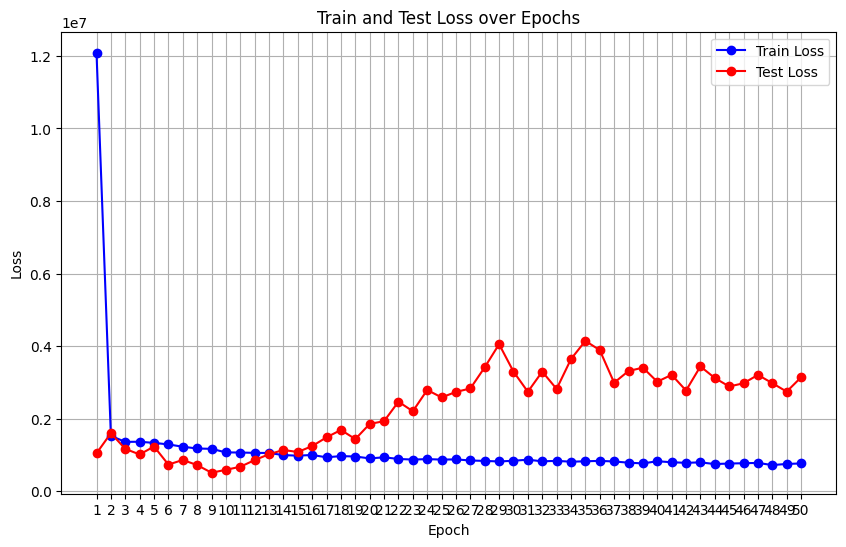

In [56]:
# Построение графиков для анализа (как мы видим, эпох оказалось много и нужно взять поменьше - попробуем 30 ниже)
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o', linestyle='-', color='r')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.show()

In [ ]:
num_epochs = 30
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train_loss = train_model(train_loader, model_2, criterion, optimizer)
    test_r2, test_loss = evaluate_model(test_loader, model_2, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test R_2: {test_r2:.4f}, Test Loss: {test_loss:.4f}')

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1/30, Train Loss: 8685914.6457, Test R_2: 0.9341, Test Loss: 1027172.7343
Epoch 2/30, Train Loss: 2268422.3248, Test R_2: 0.9095, Test Loss: 1411646.8463
Epoch 3/30, Train Loss: 2134097.6953, Test R_2: 0.9308, Test Loss: 1079320.4188
Epoch 4/30, Train Loss: 1926287.1083, Test R_2: 0.8101, Test Loss: 2964171.5103
Epoch 5/30, Train Loss: 1715922.9065, Test R_2: 0.9209, Test Loss: 1233277.6254
Epoch 6/30, Train Loss: 1631536.4270, Test R_2: 0.9201, Test Loss: 1245343.4205
Epoch 7/30, Train Loss: 1503567.0402, Test R_2: 0.8457, Test Loss: 2407492.5918
Epoch 8/30, Train Loss: 1384449.2747, Test R_2: 0.8452, Test Loss: 2412891.3381
Epoch 9/30, Train Loss: 1298093.5161, Test R_2: 0.8422, Test Loss: 2461601.8424
Epoch 10/30, Train Loss: 1265153.7910, Test R_2: 0.8559, Test Loss: 2246629.0767
Epoch 11/30, Train Loss: 1198622.4946, Test R_2: 0.8457, Test Loss: 2406785.4008
Epoch 12/30, Train Loss: 1102397.2254, Test R_2: 0.8595, Test Loss: 2191297.8750
Epoch 13/30, Train Loss: 1036546.5900

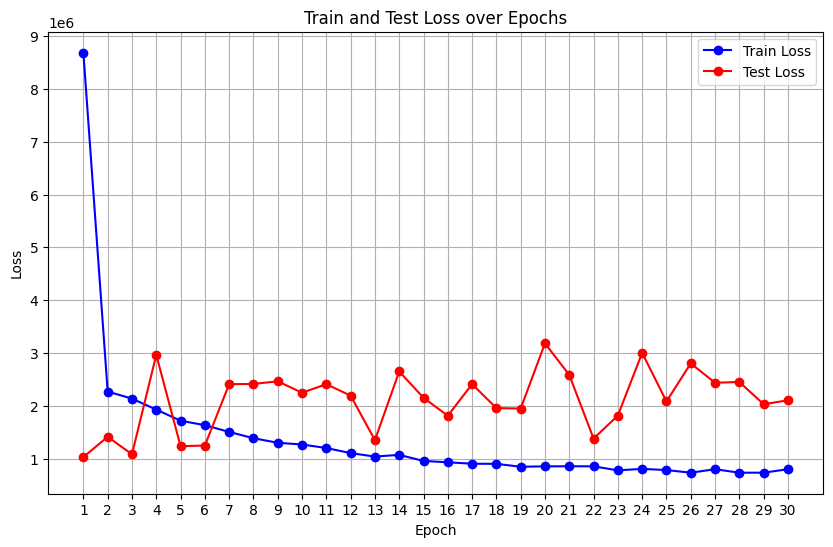

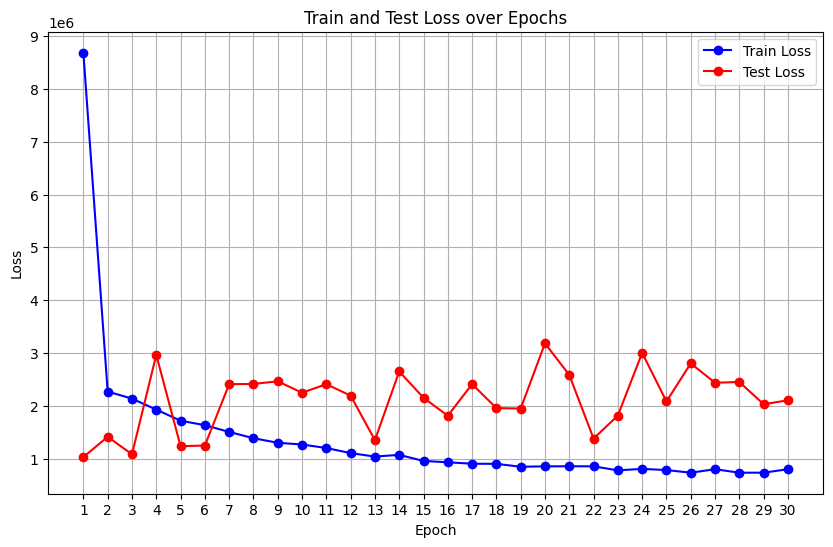

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o', linestyle='-', color='b')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o', linestyle='-', color='r')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.show()